In [1]:
from __future__ import absolute_import, division, print_function

import keras
from keras.layers import Dense, Flatten, Dropout, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
from keras import regularizers
from keras import layers
from keras.models import Sequential,load_model
from keras import backend as K
from keras.callbacks import *
from keras.initializers import glorot_normal
from keras.optimizers import SGD, Adam
from keras.constraints import max_norm
from keras.preprocessing import image
from keras.models import Model

from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from skimage.io import imsave
from skimage.feature import blob_log

import numpy as np

from IPython.display import clear_output
from matplotlib import pyplot as plt

import cv2

import pickle
import os.path
import sys
import zipfile

sys.path.append('..')
from defectfinder import gridsearch as gs

/Applications/miniconda3/envs/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
gs.detectGPU()

----Available GPUs(if GPU is detected, the code will automatically run on GPU)----
[]
----Devices imformation----
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15968614047109574751
]


In [4]:
# unzip the dataset and load
zip_ref=zipfile.ZipFile(".././dataset/dataset_noise.zip",'r')
zip_ref.extractall(".././dataset")
zip_ref.close()

In [5]:
x_train_origin=np.load(".././dataset/dataset_noise/x_train.npy")
x_test_origin=np.load(".././dataset/dataset_noise/x_test.npy")
y_train_origin=np.load(".././dataset/dataset_noise/y_train.npy")
y_test_origin=np.load(".././dataset/dataset_noise/y_test.npy")

In [6]:
# make it center to 0, and the standarddeviation is 1
x_train=(x_train_origin-np.mean(x_train_origin))/np.std(x_train_origin)
x_test=(x_test_origin-np.mean(x_train_origin))/np.std(x_train_origin)

## Test the model
* At first we use only a small amount of data to test the model. The accuracy of a good model is expected to be 1.00 (Though the validation accuracy maybe very low)

In [7]:
num_classes = 6

# input image dimensions
img_x, img_y = 64, 64
input_shape = (img_x, img_y, 1)

In [8]:
#At beginning only use very few training data
x_train_sample,y_train_sample=resample(x_train_origin,y_train_origin,n_samples=60,replace=False)
x_test_sample,y_test_sample=resample(x_test_origin,y_test_origin,n_samples=20,replace=False)

x_train_sample=(x_train_sample-np.mean(x_train_sample))/np.std(x_train_sample)
x_test_sample=(x_test_sample-np.mean(x_train_sample))/np.std(x_train_sample)

* May need to upgrade to the latest version of tensorflow when use "get_model()"

In [9]:
model=gs.get_model(0.01,0.2) #learning rate=0.01

In [16]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
        clear_output(wait=True)
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        plt.show()

plot = PlotLearning()

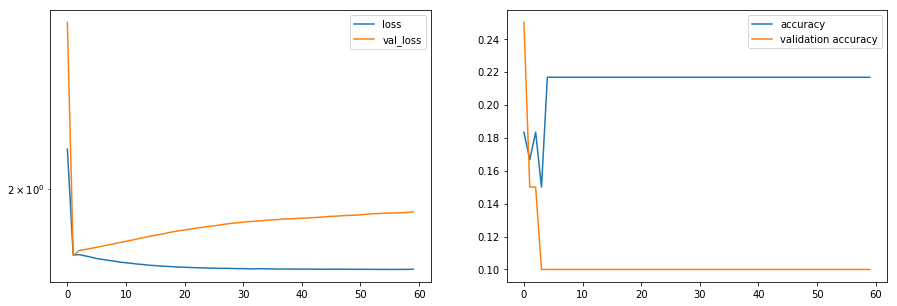

In [17]:
model.fit(x_train_sample,y_train_sample,
         batch_size=16,
         epochs=60,
         verbose=1,
         validation_data=(x_test_sample,y_test_sample),
         callbacks=[plot])

## Grid Search
* Randomly search learning rate from 1e-5 to 1e-2

In [9]:
np.random.seed(304)

learn_rate=(10**np.random.uniform(-5,0,15)).tolist() 
# this the list of learning rate you want to search

sgd_momentum=np.random.uniform(0,1,3).tolist()

batch_size=128
epochs=150

In [24]:
np.random.seed(523)
learn_rate_adam=(10**np.random.uniform(-5,-2,6)).tolist()

In [28]:
search_dropout=[0.2,0.4]

* Just as a test, set learning rate to 0.01, dropout rate to 0.2, epoch=1, search result will be saved under "../HyperparametersTuning/test"

In [10]:
# models is a list of models with learning rate from the search list
# result is a list of training history

result,models,search_grid=gs.gridsearch(x_train,y_train_origin,[0.01],[0.2],batch_size,1,
                        "test")

Train on 26895 samples, validate on 13247 samples
Epoch 1/1
26895/26895 [==============================] - 156s 6ms/step - loss: 1.7870 - acc: 0.1720 - val_loss: 1.7812 - val_acc: 0.1800


In [11]:
# load previous search grid and previous results from the same path
path="../HyperparametersTuning/learn_rate_dropoutsearch_AdamM31"

with open(path+"/search_grid.txt","rb") as fp:
    search_grid=pickle.load(fp)
    
load_res=gs.load_results(search_grid,path)

In [12]:
for i in range(len(load_res)):
    print(search_grid[i])
    print("acc:  "+str(load_res[i]['acc'][99]))
    print("valacc:  "+str(load_res[i]['val_acc'][99]))
    print("---------------------")

(1.2630177760639675e-05, 0.2)
acc:  0.8317531139617029
valacc:  0.867517173722203
---------------------
(1.2630177760639675e-05, 0.4)
acc:  0.718720951858651
valacc:  0.7859137918784086
---------------------
(1.5613045997891705e-05, 0.2)
acc:  0.8489682097066222
valacc:  0.8828413980928845
---------------------
(1.5613045997891705e-05, 0.4)
acc:  0.745454545461194
valacc:  0.8041065902163543
---------------------
(0.00016215304927075336, 0.2)
acc:  0.9636363636363636
valacc:  0.954782214859094
---------------------
(0.00016215304927075336, 0.4)
acc:  0.8960773377951292
valacc:  0.9241337661492273
---------------------
(0.00469565776713492, 0.2)
acc:  0.8861126603457892
valacc:  0.9049596135198931
---------------------
(0.00469565776713492, 0.4)
acc:  0.7462353597433732
valacc:  0.8044840341434305
---------------------
(0.00034058781883253536, 0.2)
acc:  0.9725227737519838
valacc:  0.9621046274718207
---------------------
(0.00034058781883253536, 0.4)
acc:  0.917122141662019
valacc:  0.

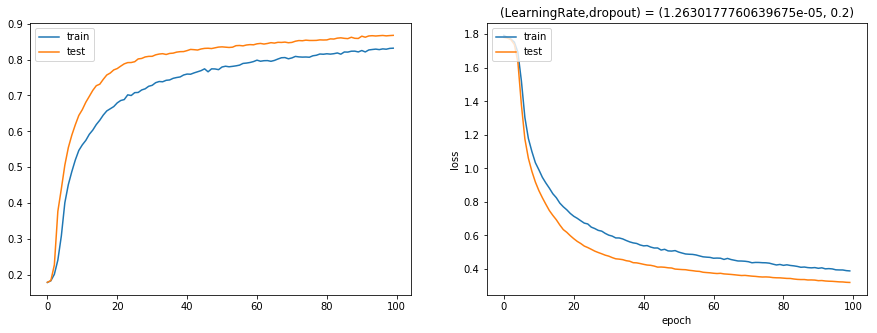

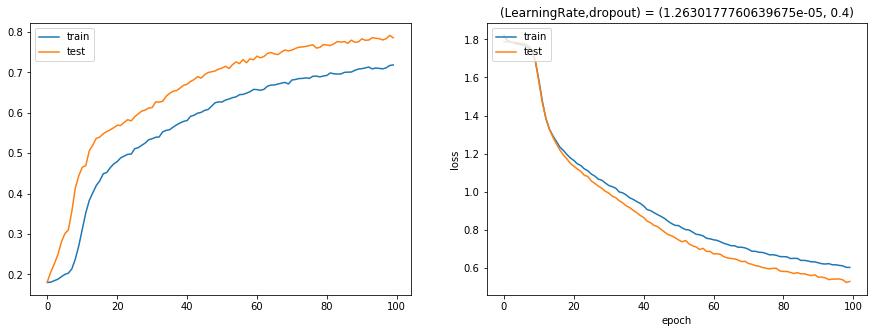

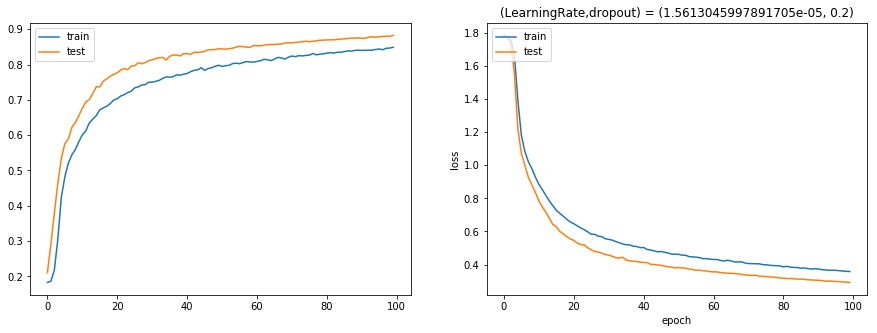

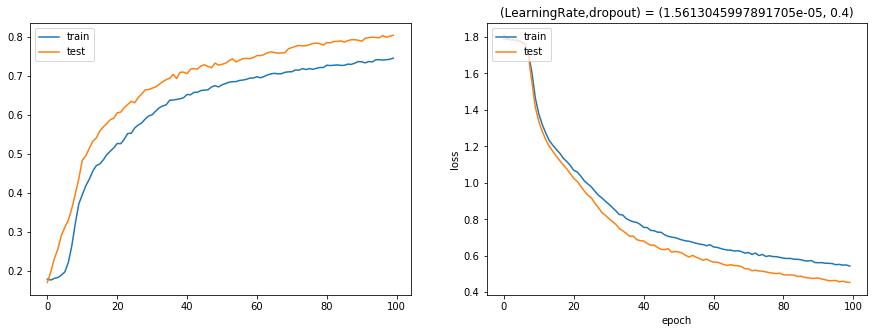

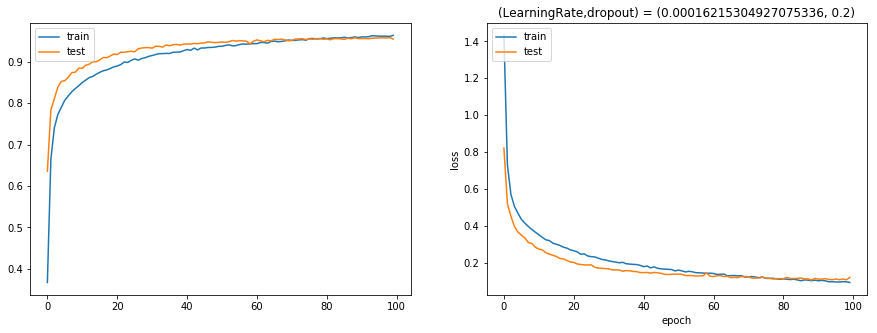

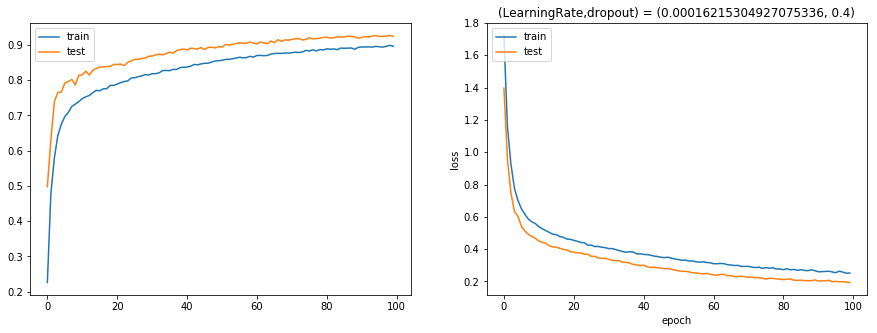

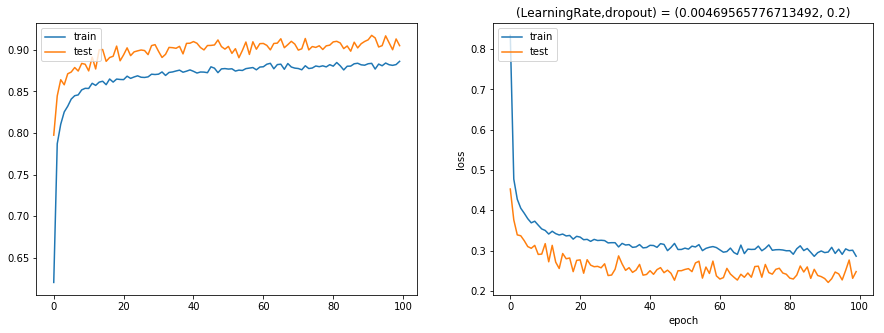

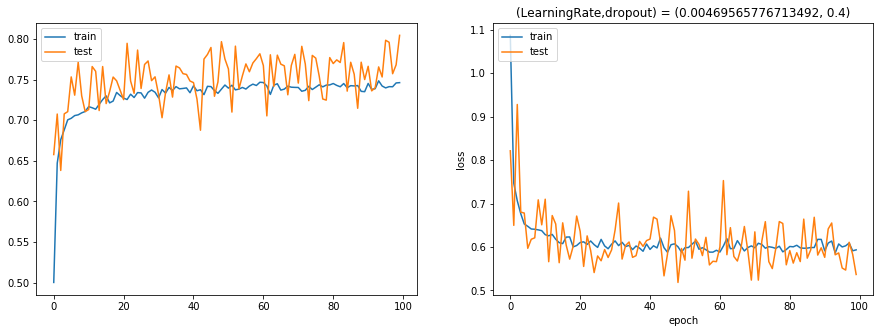

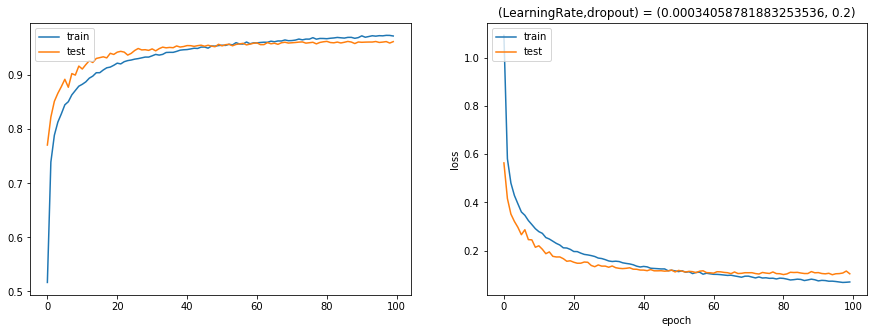

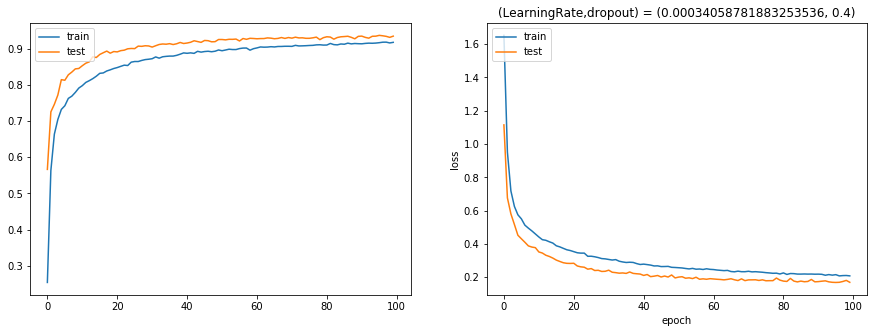

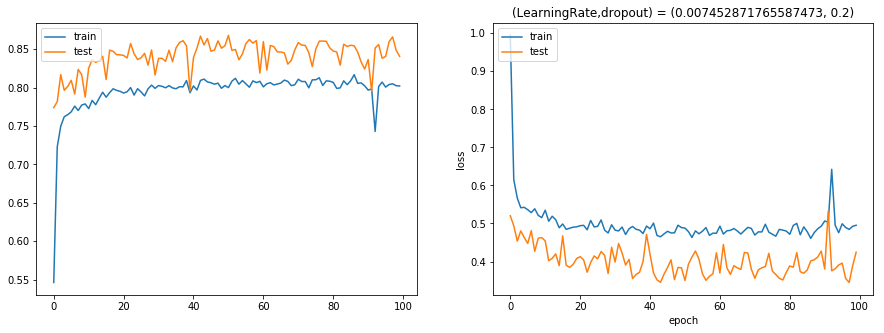

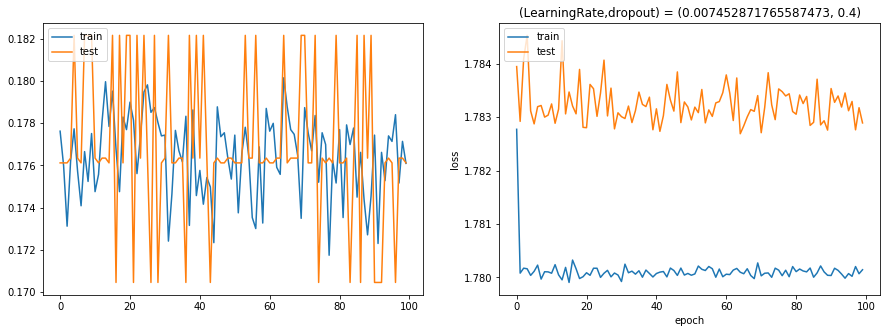

In [13]:
gs.PlotLossAcc(load_res,search_grid)

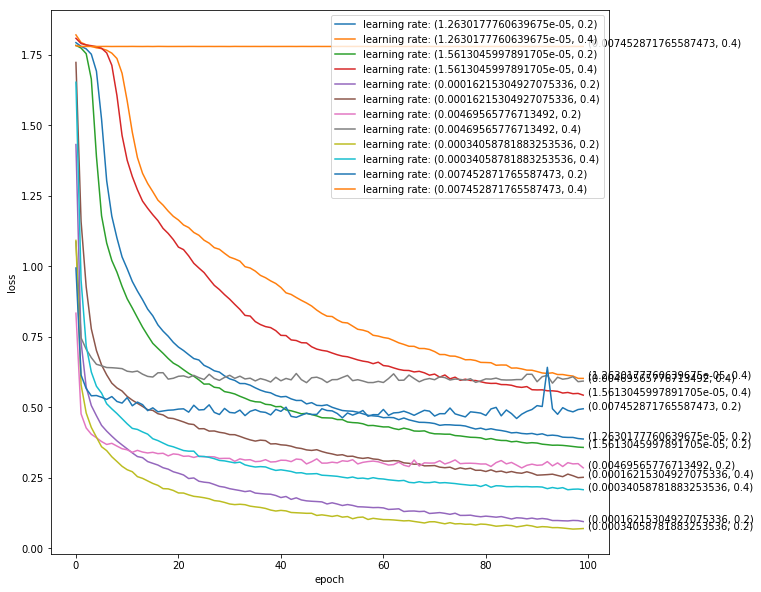

In [50]:
#plot the loss for each model
plt.figure(figsize=(10,10))

for j in range(len(load_res)):
    #if(learn_rate[j]>0.0001 and learn_rate[j]<0.02):
    plt.plot(load_res[j]['loss'],label="learning rate: "+str(search_grid[j]))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.text(100,load_res[j]['loss'][99],str(search_grid[j]))
    
plt.legend()

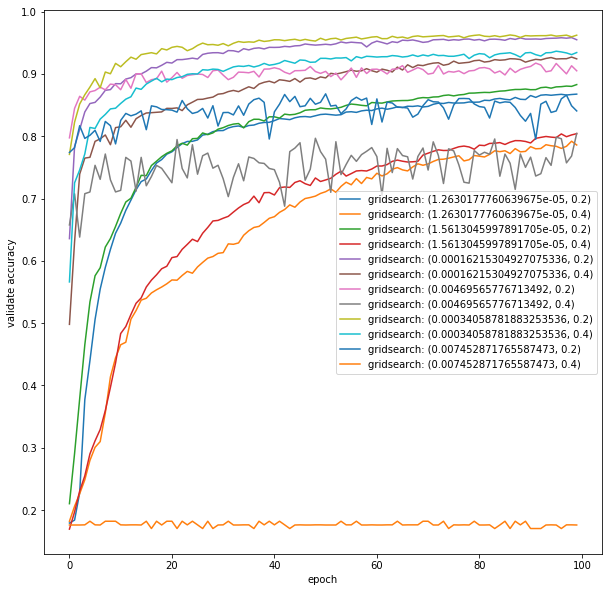

In [51]:
#plot validation accuracy for each model

plt.figure(figsize=(10,10))

for j in range(len(load_res)):
    #if(learn_rate[j]>0.001 and learn_rate[j]<0.04):
    plt.plot(load_res[j]['val_acc'],label="gridsearch: "+str(search_grid[j]))
    plt.xlabel("epoch")
    plt.ylabel("validate accuracy")
    
plt.legend()

* Get the test accuracy of a selected model

In [55]:
#get the test accuracy of a selected model
select_model=load_model("../HyperparametersTuning/learn_rate_dropoutsearch_AdamM31/model8.h5")

scores=select_model.evaluate(x_test,y_test_origin,verbose=1)

print("%s: %.2f%%" % (select_model.metrics_names[1], scores[1]*100))

10036/10036 [==============================] - 2s 211us/step
acc: 95.68%


## Narrow the range and Search Learning rate again

In [65]:
learn_rate_narrow=[0.0003,0.0007,0.001]

In [66]:
result,models,search_grid_n=gridsearch(x_train,y_train_origin,learn_rate_narrow,[0.2],batch_size,100,
                        "learn_rate_narrow_AdamM3")

Train on 26895 samples, validate on 13247 samples
Epoch 1/100
26895/26895 [==============================] - 8s 314us/step - loss: 1.0971 - acc: 0.5121 - val_loss: 0.5641 - val_acc: 0.7544
Epoch 2/100
26895/26895 [==============================] - 6s 229us/step - loss: 0.5637 - acc: 0.7398 - val_loss: 0.4347 - val_acc: 0.8158
Epoch 3/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.4821 - acc: 0.7827 - val_loss: 0.3802 - val_acc: 0.8421
Epoch 4/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.4304 - acc: 0.8132 - val_loss: 0.3500 - val_acc: 0.8536
Epoch 5/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.4004 - acc: 0.8270 - val_loss: 0.3151 - val_acc: 0.8711
Epoch 6/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.3697 - acc: 0.8426 - val_loss: 0.2992 - val_acc: 0.8772
Epoch 7/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.3474 - acc: 0.8524 - val_loss: 0.

26895/26895 [==============================] - 6s 229us/step - loss: 0.1909 - acc: 0.9235 - val_loss: 0.1574 - val_acc: 0.9373
Epoch 18/100
26895/26895 [==============================] - 6s 230us/step - loss: 0.1844 - acc: 0.9246 - val_loss: 0.1496 - val_acc: 0.9424
Epoch 19/100
26895/26895 [==============================] - 6s 230us/step - loss: 0.1802 - acc: 0.9280 - val_loss: 0.1574 - val_acc: 0.9398
Epoch 20/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.1786 - acc: 0.9304 - val_loss: 0.1445 - val_acc: 0.9446
Epoch 21/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.1676 - acc: 0.9330 - val_loss: 0.1430 - val_acc: 0.9450
Epoch 22/100
26895/26895 [==============================] - 6s 229us/step - loss: 0.1678 - acc: 0.9333 - val_loss: 0.1353 - val_acc: 0.9481
Epoch 23/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.1635 - acc: 0.9356 - val_loss: 0.1342 - val_acc: 0.9484
Epoch 24/100
26895/26895 [=======

26895/26895 [==============================] - 6s 226us/step - loss: 0.1303 - acc: 0.9503 - val_loss: 0.1386 - val_acc: 0.9493
Epoch 34/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.1172 - acc: 0.9552 - val_loss: 0.1424 - val_acc: 0.9481
Epoch 35/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.1195 - acc: 0.9553 - val_loss: 0.1364 - val_acc: 0.9502
Epoch 36/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.1344 - acc: 0.9503 - val_loss: 0.1322 - val_acc: 0.9506
Epoch 37/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.1110 - acc: 0.9573 - val_loss: 0.1401 - val_acc: 0.9493
Epoch 38/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.1124 - acc: 0.9563 - val_loss: 0.1327 - val_acc: 0.9513
Epoch 39/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.1123 - acc: 0.9569 - val_loss: 0.1449 - val_acc: 0.9486
Epoch 40/100
26895/26895 [=======

In [82]:
# load previous search grid and previous results from the same path
path="../HyperparametersTuning/learn_rate_narrow_AdamM31"

with open(path+"/search_grid.txt","rb") as fp:
    search_grid=pickle.load(fp)
    
load_res=gs.load_results(search_grid,path)

In [83]:
for i in range(len(load_res)):
    print(search_grid[i])
    print("acc:  "+str(load_res[i]['acc'][99]))
    print("valacc:  "+str(load_res[i]['val_acc'][99]))
    print("---------------------")

(0.0003, 0.2)
acc:  0.9717419594720208
valacc:  0.9585566543638279
---------------------
(0.0007, 0.2)
acc:  0.9707380554006321
valacc:  0.9624820714213942
---------------------
(0.001, 0.2)
acc:  0.9730433166015988
valacc:  0.9557635691234856
---------------------


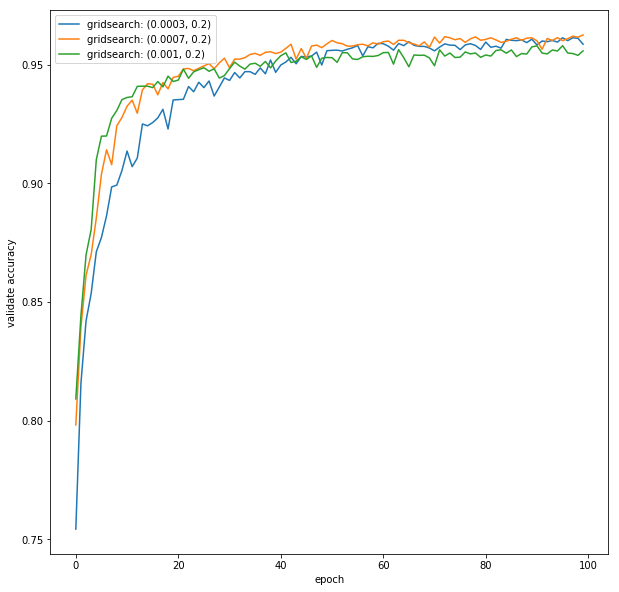

In [69]:
plt.figure(figsize=(10,10))

for j in range(len(load_res)):
    #if(learn_rate[j]>0.001 and learn_rate[j]<0.04):
    plt.plot(load_res[j]['val_acc'],label="gridsearch: "+str(search_grid[j]))
    plt.xlabel("epoch")
    plt.ylabel("validate accuracy")
    
plt.legend()

In [164]:
#get the test accuracy of a selected model
select_model=load_model("../HyperparametersTuning/learn_rate_narrow_AdamM31/model1.h5")

scores=select_model.evaluate(x_test,y_test_origin,verbose=1)

print("%s: %.2f%%" % (select_model.metrics_names[1], scores[1]*100))

10036/10036 [==============================] - 3s 262us/step
acc: 96.04%


## Some other CNN structures we also tested
* a CNN with SGD optimizer,0.2 dropout rate

In [17]:
path="../HyperparametersTuning/0.2dropout_momentum1"

with open(path+"/search_grid.txt","rb") as fp:
    search_grid=pickle.load(fp)

load_res=gs.load_results(search_grid,"../HyperparametersTuning/0.2dropout_momentum1")

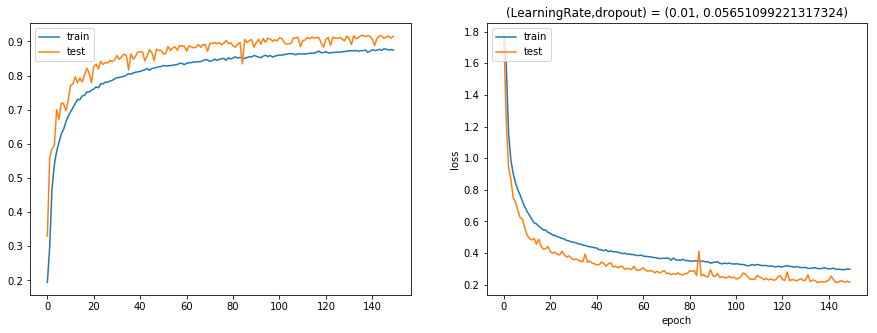

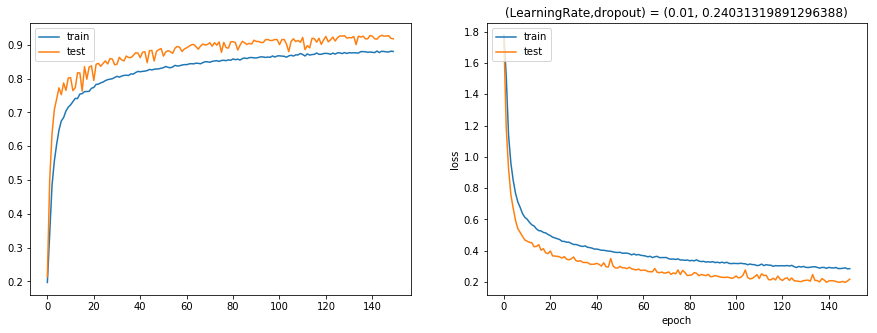

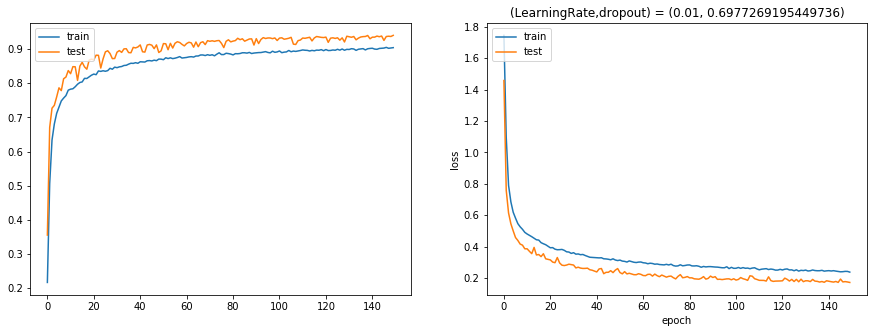

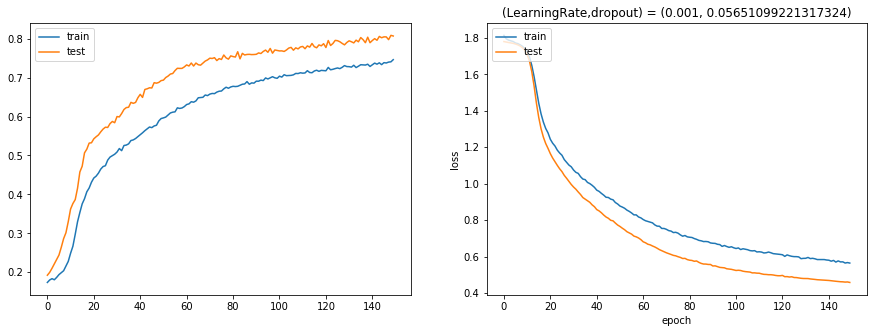

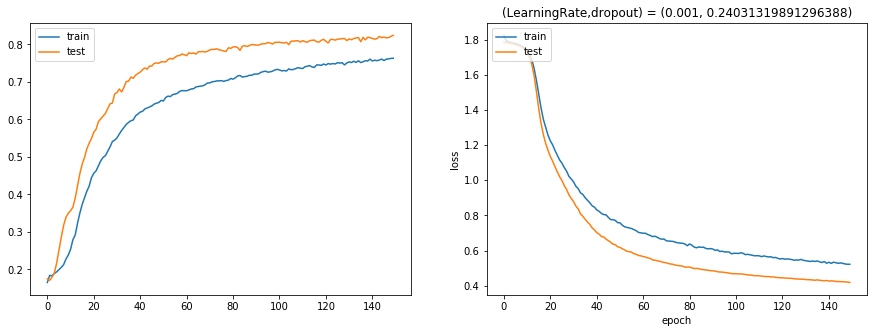

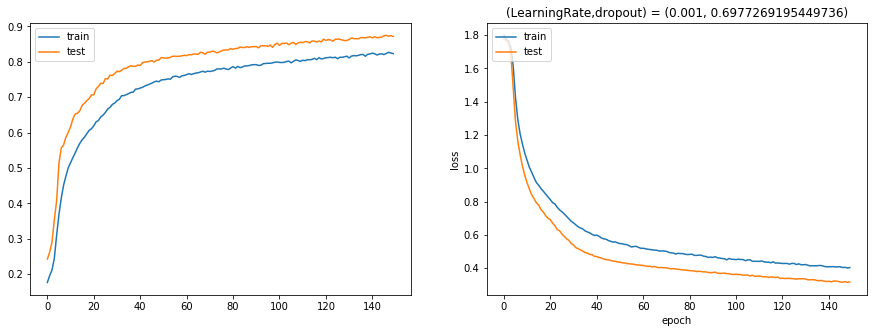

In [18]:
gs.PlotLossAcc(load_res,search_grid)

## Class Activation Map
* plot the CAM with a selected model

In [19]:
model=load_model("../HyperparametersTuning/learn_rate_narrow_AdamM31/model1.h5")

predicted defect type:
Vs2
coordinates: 
[(63.0, 63.0), (0.0, 0.0)]


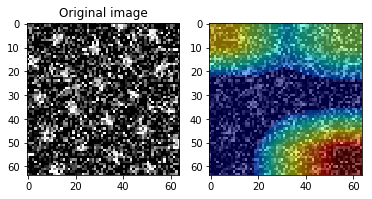

In [20]:
heatmap=gs.visualize_class_activation_map(model, x_test_origin[1])

* defectslist: 'Sw','Mo','W2s2','Vw','Vs2','Ws'

In [148]:
y_test_origin[1]

array([0., 0., 0., 0., 1., 0.], dtype=float32)